In [1]:
import numpy as np 
import pandas as pd 
import json 
import ccxt 
import seaborn as sns
import os 
import pandas_ta as ta 
import time
from datetime import datetime, timedelta
import math
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt 
from transformers import * 
import torch 
from torch import Tensor 
from torch.utils.data import * 
import torch.nn as nn 
import torch.nn.functional as F 
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from pytorch_metric_learning import miners, losses
from pytorch_metric_learning.distances import CosineSimilarity
from scipy.spatial.distance import cdist 
import pickle

def one_hot(x, dims, gpu = True):
    out = []
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    
    if(not gpu):
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
    
    # print("Converting to one hot vector")
    for i in range(0, x.shape[-1]): # get rid of tqdm for training 
        x_ = x[:,:,i].byte().cpu().long().unsqueeze(-1)
        o = torch.zeros([batch_size, seq_len, dims[i]]).long()

        o.scatter_(-1, x_,  1)
        out.append(o.type(dtype))
    return out

def a_norm(Q, K): 
    m = torch.matmul(Q, K.transpose(2,1).float()) 
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float()) 
    return torch.softmax(m, -1) 

def attention(Q, K, V): 
    a = a_norm(Q, K) # (batch_size, dim_attn, seq_length) 
    return torch.matmul(a, V) # (batch_size, seq_length, seq_length) 

class AttentionBlock(torch.nn.Module): 
    def __init__(self, dim_val, dim_attn): 
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val) 
        self.key = Key(dim_val, dim_attn) 
        self.query = Query(dim_val, dim_attn) 
    
    def forward(self, x, kv = None):
        if kv is None:
            # Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        # Attention with x as Q, external vector kv as K and V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False).cuda()
    def forward(self, x):
        return self.fc1(x)

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    def forward(self, x):
        return self.fc1(x)

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    def forward(self, x):
        return self.fc1(x)

def QuantileLoss(net_out, Y, q):
    return (q * F.relu(net_out - Y)) + ((1 - q) * F.relu(Y - net_out))


class GLU(torch.nn.Module):
    def __init__(self, dim_input):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_input)
        self.fc2 = nn.Linear(dim_input, dim_input)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x)) * self.fc2(x) 
    
class GRN(torch.nn.Module): 
    def __init__(self, dim_input, dim_out=None, n_hidden=10, dropout_r=0.1):
        super(GRN, self).__init__() 
        if dim_out != None: 
            self.skip = nn.Linear(dim_input, dim_out) 
        else:
            self.skip = None
            dim_out = dim_input 
        self.fc1 = nn.Linear(dim_input, n_hidden) 
        self.fc2 = nn.Linear(n_hidden, dim_out) 
        self.dropout = nn.Dropout(dropout_r) 
        self.gate = GLU(dim_out) 
        self.norm = nn.LayerNorm(dim_out) 
        
    def forward(self, x):
        a = F.elu(self.fc1(x))
        a = self.dropout(self.fc2(a))
        a = self.gate(a)
        if self.skip != None:
            return self.norm(self.skip(x) + a)
        return self.norm(x + a)
    
class VSN(torch.nn.Module): 
    def __init__(self, n_var_cont, n_var_disc, dim_model, dropout_r=0.1): 
        super(VSN, self).__init__()
        n_var_total = n_var_cont + len(n_var_disc)
        # linear transformation of inputs into dmodel vectors 
        self.linearise = []
        for i in range(n_var_cont): 
            self.linearise.append(nn.Linear(1, dim_model, bias=False).cuda()) 
        
        self.fc = nn.Linear(1, dim_model, bias=False).cuda()     
        # entity embeddings for discrete inputs 
        self.entity_embed = [] 
        for i in n_var_disc: 
            self.entity_embed.append(nn.Linear(i, dim_model, bias=False).cuda())  
        
        self.input_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.vs_grn = GRN(n_var_total * dim_model, dim_out=n_var_total, dropout_r = dropout_r)
    
    # input (batch_size, seq_len, n_variables, input_size)
    def forward(self, x_cont, x_disc): 
        # linearise continuous inputs 
        linearised = [] 
        for idx, fc in enumerate(self.linearise): 
            linearised.append(fc(x_cont[:,:,idx])) 
        # entity embeddings for discrete inputs 
        embedded = []
        
        for x, fc in zip(x_disc, self.entity_embed): 
            embedded.append(fc(x)) 
        if len(self.linearise) != 0 and len(self.entity_embed) != 0: 
            linearised = torch.stack(linearised, dim=-2) 
            embedded = torch.stack(embedded, dim=-2)    
            vectorised_vars = torch.cat((linearised, embedded), dim=-2) # (batch_size, seq_len, dim_model, n_vars_total)
        elif len(self.linearise) != 0 and len(self.entity_embed) == 0: 
            vectorised_vars = torch.stack(linearised, dim=-2) # (batch_size, seq_len, n_var_cont, dim_model)
        elif len(self.entity_embed) != 0 and len(self.linearise) == 0: 
            vectorised_vars = torch.stack(embedded, dim=-2)
        
        # flatten everything except accross batch for variable selection weights 
        vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim=2)) # (batch_size, seq_len, n_variables)
        vs_weights = torch.softmax(vs_weights, dim=-1).unsqueeze(-1) # (batch_size, seq_len, n_variables, 1) 
        
        # input_grn applied to every input separately 
        input_weights = self.input_grn(vectorised_vars) # (batch_size, seq_len, n_variables, dim_model)
        
        x = torch.sum((vs_weights * input_weights), dim = 2) 
        return x, vs_weights # returns (batch_size, seq_len, dim_model)
    
class LSTMLayer(torch.nn.Module): 
    def __init__(self, dim_model, n_layers = 1, dropout_r = 0.1):
        super(LSTMLayer, self).__init__()
        self.n_layers = n_layers 
        self.dim_model = dim_model 
        self.lstm = nn.LSTM(dim_model, dim_model, num_layers = n_layers, batch_first = True) 
        self.hidden = None
        self.dropout = nn.Dropout(dropout_r) 
    
    # takes input (batch_size, seq_len, dim_model)
    def forward(self, x): 
        if self.hidden == None: 
            raise Exception("Call reset() to initialise LSTM Layer") 
            
        x, self.hidden = self.lstm(x, self.hidden) 
        x = self.dropout(x) 
        return x, self.hidden # returns (batch_size, seq_len, dim_model), hidden 
    
    def reset(self, batch_size, gpu = True): 
        if not gpu: 
            dtype = torch.FloatTensor 
        else: 
            dtype = torch.cuda.FloatTensor
        self.hidden = (torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype),
                       torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype)) 

class AttentivePooling(torch.nn.Module):
    def __init__(self, input_dim):
        super(AttentivePooling, self).__init__()
        self.W = nn.Linear(input_dim, 1)
    def forward(self, x):
        softmax = F.softmax
        att_w = softmax(self.W(x).squeeze(-1)).unsqueeze(-1)
        x = torch.sum(x * att_w, dim=1)
        return x
    
class TFN(torch.nn.Module): 
    def __init__(self, 
                 n_var_past_cont, 
                 n_var_future_cont,
                 n_var_past_disc, 
                 n_var_future_disc,
                 dim_model,
                 n_quantiles = 1, 
                 dropout_r = 0.1,
                 n_lstm_layers = 1,
                 n_attention_layers = 1,
                 n_heads = 4):
        super(TFN, self).__init__()
        self.vs_past = VSN(n_var_past_cont, n_var_past_disc, dim_model, dropout_r = dropout_r) 
        self.vs_future = VSN(n_var_future_cont, n_var_future_disc, dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        
        self.gate1 = GLU(dim_model) 
        self.norm1 = nn.LayerNorm(dim_model) 
        
        self.static_enrich_grn = GRN(dim_model, dropout_r = dropout_r)
        
        self.attention = [] 
        for i in range(n_attention_layers): 
            self.attention.append([MultiHeadAttentionBlock(dim_model, dim_model, n_heads = n_heads).cuda(),
                                   nn.LayerNorm(dim_model).cuda()]) 
        
        self.norm2 = nn.LayerNorm(dim_model) 
        self.positionwise_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.norm3 = nn.LayerNorm(dim_model) 
        self.dropout = nn.Dropout(dropout_r) 
        self.fc_out = nn.Linear(dim_model, n_quantiles) 
        
        # self.attentive_pooler = AttentivePooling(n_quantiles)
        
    # takes input (batch_size, past_seq_len, n_variables_past) 
    # and (batch_size, future_seq_len, n_variables_future) 
    def forward(self, x_past_cont, x_past_disc, x_future_cont, x_future_disc):
        # Encoder 
        x_past, vs_weights = self.vs_past(x_past_cont, x_past_disc) 
        e, e_hidden = self.enc(x_past) 
        self.dec_hidden = e_hidden 
        e = self.dropout(e) 
        x_past = self.norm1(self.gate1(e) + x_past) 

        # Decoder
        x_future, _ = self.vs_future(x_future_cont, x_future_disc) 
        d, _ = self.dec(x_future) 
        d = self.dropout(d) 
        x_future = self.norm1(self.gate1(d) + x_future) 

        # static enrichment
        x = torch.cat((x_past, x_future), dim=1) # (batch_size, past_seq_len + future_seq_len, dim_model)
        attention_res = x_future
        x = self.static_enrich_grn(x) 

        # attention layer 
        a = self.attention[0][1](self.attention[0][0](x) + x) 
        for at in self.attention[1:]:
            a = at[1](at[0](a) + a) 
        x_future = self.norm2(a[:, x_past.shape[1]:] + x_future) 
        a = self.positionwise_grn(x_future) 
        x_future = self.norm3(a + x_future + attention_res) 
        net_out = self.fc_out(x_future)  
        # net_out = self.attentive_pooler(net_out) 
        return net_out, vs_weights 

    def reset(self, batch_size, gpu = True): 
        self.enc.reset(batch_size, gpu) 
        self.dec.reset(batch_size, gpu) 
        
        
with open("BTC_USDT-1h-12.json") as f: 
        d = json.load(f) 

chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"})

def process(df): 
        binance = ccxt.binance() 
        dates = df["timestamp"].values 
        timestamp = [] 
        for i in range(len(dates)):
                date_string = binance.iso8601(int(dates[i])) 
                date_string = date_string[:10] + " " + date_string[11:-5] 
                timestamp.append(date_string) 
        df["datetime"] = timestamp
        df = df.drop(columns={"timestamp"}) 
        return df 

chart_df = process(chart_df) 

hours, days, months, years = [],[],[],[] 
for dt in tqdm(chart_df["datetime"]):
        dtobj = pd.to_datetime(dt) 
        hour = dtobj.hour 
        day = dtobj.day 
        month = dtobj.month 
        year = dtobj.year 
        hours.append(hour) 
        days.append(day) 
        months.append(month) 
        years.append(year) 

chart_df["hours"] = hours 
chart_df["days"] = days  
chart_df["months"] = months 
chart_df["years"] = years 

close = chart_df["close"].values 
datetimes = chart_df["datetime"].values 

lookback_window = 24
forecast_window = 6 

date_chart_df = {} 

for i in tqdm(range(lookback_window, len(datetimes)-forecast_window)): 
    dtobj = datetime.strptime(str(datetimes[i]), "%Y-%m-%d %H:%M:%S")  
    date_chart_df[dtobj] = (close[i-lookback_window+1:i+1], close[i+1:i+1+forecast_window])
    
with open("similarity_dict_top_10.pkl", "rb") as f: 
    similarity_dict = pickle.load(f) 
    
def get_cur_label(past, future): 
    last_close = past[-1]  
    maxhigh, minlow = np.max(future), np.min(future) 
    high_delta = (maxhigh - last_close) / last_close * 100.0 
    low_delta = (minlow - last_close) / last_close * 100.0  
    if high_delta >= 1.0 or low_delta <= -1.0: 
        if high_delta >= np.abs(low_delta): 
            return 0 
        elif high_delta < np.abs(low_delta): 
            return 1 
    else: 
        return 2 
    
past_cont = [] 
future_cont = [] 
past_dates = [] 
future_dates = [] 
labels = [] 
target_seqs = []

for key, value in tqdm(similarity_dict.items(), position=0, leave=True): 
    past_seq = date_chart_df[key][0] 
    future_seq = date_chart_df[key][1] 
    
    returns = [] 
    future_returns = [] 
    rets = [] 
    for i in range(1, len(past_seq)): 
        ret = past_seq[i] / past_seq[i-1] 
        rets.append(ret) 
    returns.append(rets)    
    
    for i in range(len(value[:1])): 
        sim_past_seq = date_chart_df[value[i]][0] 
        sim_future_seq = date_chart_df[value[i]][1] 
        sim_returns = []
        for j in range(1, len(sim_past_seq)): 
            ret = sim_past_seq[j] / sim_past_seq[j-1] 
            sim_returns.append(ret) 
        returns.append(sim_returns) 
        sim_future_returns = [] 
        for j in range(0, len(sim_future_seq)): 
            if j == 0: 
                ret = sim_future_seq[j] / sim_past_seq[-1] 
            else: 
                ret = sim_future_seq[j] / sim_future_seq[j-1] 
            sim_future_returns.append(ret) 
        future_returns.append(sim_future_returns) 
    past_cont.append(returns) 
    future_cont.append(future_returns) 
    
    
    target_returns = [] 
    for i in range(0, len(future_seq)): 
        if i == 0: 
            ret = future_seq[i] / past_seq[-1] 
        else:
            ret = future_seq[i] / future_seq[i-1] 
        target_returns.append(ret) 
    
    target_seqs.append(target_returns) 
    
    label = get_cur_label(past_seq, future_seq)
    
    labels.append(label) 
    
    cur_date = key - timedelta(hours=22)
    past_date, future_date = [], [] 
    for i in range(23): 
        past_date.append([cur_date.month, cur_date.day, cur_date.hour]) 
        cur_date = cur_date + timedelta(hours=1)   
    for i in range(6):
        future_date.append([cur_date.month, cur_date.day, cur_date.hour]) 
        cur_date = cur_date + timedelta(hours=1) 
        
    past_dates.append(past_date) 
    future_dates.append(future_date)
    
past_cont = np.array(past_cont) 
future_cont = np.array(future_cont) 


past_cont = torch.tensor(past_cont).float() 
past_cont = torch.reshape(past_cont, (-1, 23, 2, 1)) 

future_cont = torch.tensor(future_cont).float() 
future_cont = torch.reshape(future_cont, (-1, 6, 1, 1))

past_dates = torch.tensor(past_dates) 

future_dates = torch.tensor(future_dates) 

labels = torch.tensor(labels, dtype=int) 

target_seqs = torch.tensor(target_seqs)  


print(past_cont.shape, future_cont.shape, past_dates.shape, future_dates.shape, target_seqs.shape) 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = TFN(n_var_past_cont=2, 
            n_var_future_cont=1,
            n_var_past_disc=[13, 32, 24], 
            n_var_future_disc=[13, 32, 24], 
            dim_model=160)

checkpoint = torch.load("1_24_FE_4.8080254600790795e-05.pt") 
print(model.load_state_dict(checkpoint))

model.to(device) 
print()

train_size = int(0.8 * past_cont.shape[0]) 
val_size = int(0.1 * past_cont.shape[0]) 

train_past_cont = past_cont[:train_size] 
train_past_dates = past_dates[:train_size] 
train_future_cont = future_cont[:train_size] 
train_future_dates = future_dates[:train_size] 
train_labels = labels[:train_size] 
train_target_seqs = target_seqs[:train_size] 

val_past_cont = past_cont[train_size:train_size+val_size] 
val_past_dates = past_dates[train_size:train_size+val_size] 
val_future_cont = future_cont[train_size:train_size+val_size] 
val_future_dates = future_dates[train_size:train_size+val_size] 
val_labels = labels[train_size:train_size+val_size] 
val_target_seqs = target_seqs[train_size:train_size+val_size] 

test_past_cont = past_cont[train_size+val_size:] 
test_past_dates = past_dates[train_size+val_size:]  
test_future_cont = future_cont[train_size+val_size:] 
test_future_dates = future_dates[train_size+val_size:] 
test_labels = labels[train_size+val_size:] 
test_target_seqs = target_seqs[train_size+val_size:] 

batch_size = 128 

class CustomDataset(Dataset): 
    def __init__(self, past_cont, past_disc, future_cont, future_disc, target_seq): 
        self.past_cont = past_cont 
        self.past_disc = past_disc 
        self.future_cont = future_cont 
        self.future_disc = future_disc 
        self.target_seq = target_seq
    def __len__(self): 
        return len(self.past_cont) 
    def __getitem__(self, i): 
        return {
            "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32), 
            "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32), 
            "future_cont": torch.tensor(self.future_cont[i], dtype=torch.float32), 
            "future_disc": torch.tensor(self.future_disc[i], dtype=torch.float32), 
            "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32), 
        }

train_dataset = CustomDataset(train_past_cont, train_past_dates, train_future_cont, train_future_dates, train_target_seqs) 
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

val_dataset = CustomDataset(val_past_cont, val_past_dates, val_future_cont, val_future_dates, val_target_seqs) 
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 

test_dataset = CustomDataset(test_past_cont, test_past_dates, test_future_cont, test_future_dates, test_target_seqs) 
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 



/opt/conda/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


  0%|          | 0/47346 [00:00<?, ?it/s]

  0%|          | 0/47316 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

torch.Size([4147, 23, 2, 1]) torch.Size([4147, 6, 1, 1]) torch.Size([4147, 23, 3]) torch.Size([4147, 6, 3]) torch.Size([4147, 6])
<All keys matched successfully>



In [4]:
predictions, gt = [], [] 

loss_func = nn.L1Loss() 
model.eval() 
test_loss = 0
for step, batch in tqdm(enumerate(test_dataloader), position=0, leave=True, total=len(test_dataloader)): 
    past_cont = batch["past_cont"].to(device) 
    past_disc = batch["past_disc"].to(device) 
    future_cont = batch["future_cont"].to(device) 
    future_disc = batch["future_disc"].to(device) 
    target_seq = batch["target_seq"].to(device) 
        
    model.reset(batch_size=past_cont.shape[0], gpu=True)
    past_disc = one_hot(past_disc, [13, 32, 24]) 
    future_disc = one_hot(future_disc, [13, 32, 24])  
    with torch.no_grad():
        net_out, vs_weights = model(past_cont, past_disc, future_cont, future_disc) 
    net_out = torch.reshape(net_out, (-1, forecast_window))
    
    for i in range(net_out.shape[0]):  
        predictions.append(net_out[i].detach().cpu().numpy()) 
        gt.append(target_seq[i].detach().cpu().numpy()) 
        
    loss = loss_func(net_out, target_seq)  
    test_loss += loss.item() 
avg_test_loss = test_loss / len(test_dataloader) 

avg_test_loss

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_32020/2583100947.py:504: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_32020/2583100947.py:505: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_32020/2583100947.py:506: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "future_cont": torch.tensor(self.future_cont[i], dtype=torch.float32),
/tmp/ipykernel_32020/2583100947.py:507: UserWarning: To copy construct from a ten

0.17586785927414894

In [7]:
cnt = 0 

for i in range(len(predictions)): 
    gt_returns = [] 
    for j in range(len(gt[i])): 
        if j == 0: 
            gt_returns.append(gt[i][j]) 
        else:
            prod = 1 
            for k in range(0, j+1): 
                prod *= gt[i][k] 
            gt_returns.append(prod) 
    pred_returns = [] 
    for j in range(len(predictions[i])): 
        if j == 0: 
            pred_returns.append(predictions[i][j]) 
        else:
            prod = 1 
            for k in range(0, j+1): 
                prod *= predictions[i][k] 
            pred_returns.append(prod) 
            
    pred_short, pred_long = False, False 
    gt_short, gt_long = False, False 
    
    for j in range(len(pred_returns)): 
        if pred_returns[j] <= 0.99:
            pred_short = True 
        elif pred_returns[j] >= 1.01:
            pred_long = True 
        if gt_returns[j] <= 0.99: 
            gt_short = True 
        elif gt_returns[j] >= 1.01: 
            gt_long = True 
            
    if pred_short == True and gt_short == True: 
        cnt += 1 
    elif pred_long == True and gt_long == True: 
        cnt += 1 
    elif pred_long == False and gt_long == False and pred_short == False and gt_short == False: 
        cnt += 1 
        
cnt / len(predictions) * 100 

47.355769230769226

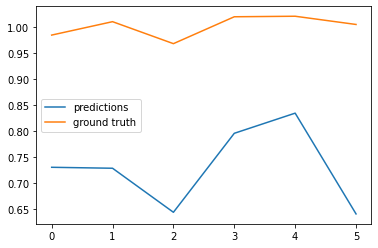

In [6]:
plt.plot(predictions[50], label="predictions") 
plt.plot(gt[50], label="ground truth") 
plt.legend() 